<a href="https://colab.research.google.com/github/freddy0218/2025_MLEES_book_online/blob/main/notebook_dl/ldm_env_notebook_empty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning to downscale coarse climate fields using Latent Diffusion (DiffScaler)

The requirements file had to be cleaned for cross platform compatibility. (between VSCode and Google Colab). Run the cell below to make sure your updated requirements file exists so that you can have all the packages you need to run the rest of the notebook.

For purposes of running this notebook, please go ahead and download the zipped folder here first : [Link to download data](https://unils-my.sharepoint.com/:u:/g/personal/tom_beucler_unil_ch/IQA3TQTejnX8RouMelcE_iVqATneiE7rN7_9tnqQWZXlerw?e=jJuFeF) and place it in your google drive under MyDrive/ after unzipping it locally first. Make sure you retain the original name of the fiolder: data_LDM. So the path to the folder should look like drive/MyDrive/data_LDM . Please note that if you dont do this step, you would be unfortunately unable to move forward with the notebook.

Run the below two cells so that the packages required can be aggregated into a neat requirements_updated.txt file, for downloading in your notebook.

In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls /content/drive/MyDrive/data_LDM/

2020  checkpoints  preprocessing.py  requirements.txt  static_vars  stats.json


In [ ]:
# @title
input_file = "/content/drive/MyDrive/data_LDM/requirements.txt" #the requirements file from VSCode
output_file = "requirements_updated.txt" #requirements file for colab

with open(input_file, "r") as infile, open(output_file, "w") as outfile:
    for line in infile:
        if "@ file://" in line:
            pkg = line.split("@")[0].strip()
            if pkg:
                outfile.write(f"{pkg}\n")
        else:
            outfile.write(line)

The below cell is for installing all packages you require to run the rest of the notebook. Post installation, it might ask you to restart runtime. Kindly do so.

In [ ]:
# @title
!pip install -r requirements_updated.txt #This will install all the required packages with the version you need to run this notebook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.0 MB/s eta 0:00:00
Reason for being yanked: The Windows wheels, under some conditions, caused segfaults in unrelated user code.  Due to this we deleted the Windows wheels to prevent these segfaults, however this caused greater disruption as pip then began to try (and fail) to build 3.9.1 from the sdist on Windows which impacted far more users.  Yanking the whole release is the only tool available to eliminate these failures without changes to on the user side.  The sdist, OSX wheel, and manylinux wheels are all functional and there are no critical bugs in the release.   Downstream packagers should not yank their builds of Matplotlib 3.9.1.  See https://github.com/matplotlib/matplotlib/issues/28551 for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 MB 1.1 M

For this exercise we shall be using Pytorch library for training our Latent Diffusion Model, with a lightweight wrapper called PytorchLightning to make the code cleaner, organised, and scalable: the essential attributes in all of Machine Learning.

Go ahead and click on the below cell to import all the libraries for this session

In [ ]:
# @title
import torch
torch.set_float32_matmul_precision('medium')
from torch import nn
from torch.utils.data import DataLoader, Dataset
from lightning import LightningModule, LightningDataModule, Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
import torch.nn.functional as F
import random
import zstandard
import os
import glob
import io
import numpy as np
import xarray as xr
from torch.utils.data import Dataset, DataLoader, random_split
import rasterio
import rioxarray
from torch.utils.data import TensorDataset, DataLoader
import json

## Downscaling in Earth System Modeling
Downscaling based on deep learning is a key application in Earth System Modelling, and involves generating the high resolution fields from coarse simulations. Probabilistic DL models (like diffusion as seen in previous notebooks) can also provide uncertainty quantification due to their capability of generating multiple outputs for each coarse input. For more on climate downscaling, refer to this beginner-friendly resource : https://www.gfdl.noaa.gov/climate-model-downscaling/

###About the paper (Tomasi et.al.,2025) and our altered approach
The paper this notebook is based on, can be accessed at https://gmd.copernicus.org/articles/18/2051/2025/ . The authors use a Latent Diffusion Model (LDM_res) to downscale ERA5 data over Italian domain up to a resolution of 2 km, using COSMO-CLM simulations as ground truth. The original setup contains 14 ERA5 input channels to predict 2 chanels : temperature and wind speed. This is called perfect prognosis downscaling, where large scale predictors are used to predict local high resolution predictands.


However, for the purposes of this notebook, the code from the original repository from the paper has been repurposed ro use a limited dataset. We shall be predicting high res 2m temperature COSMO-CLM target fields conditioned on static inputs along with low res 2m temperature ERA5 fields.

Data : We are using hourly data from a single year here, 2020, with random split for training,validation and testing. This random splitting ensures a uniform distribution of samples across years, months, and hours of the day in all three datasets. Note that random split might not suit all situations, and your choice of split depends on what you want the model to learn, and how you want it to generalise (for eg., decadal variability on climatic timescales)

There are three static variables provided to the model in addition to 2m ERA5 temperature field. These are as follows :

 1. digital elevation model (DEM),

 2. land cover bands and

 3. latitude

This is our domain

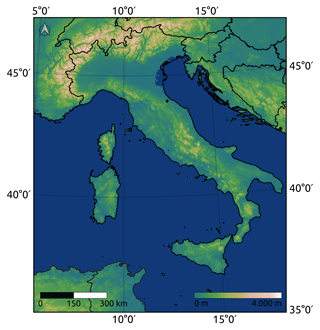

### Learning objectives :

By the end of this exercise , you will learn 🇰

1. How PytorchLightning wrapper can become indispensable to writing clean, modular, customisable and scalable code

2. How to hierarchically "refine" a spatially coarse (low resolution) field using a highly simplified version of the Latent Diffusion hierarchy of models from Tomasi et.al.,2025 using the concept of "residual learning".

3. How reparameterisation trick works to make gradient descent possible in complex diffusion architectures such as LDM

4. How configuration managers can be used to conduct experiments without the need to change the source code.

In [ ]:
# @title
# Copy the preprocessing script from Google Drive to the current directory for easier access
!cp "/content/drive/MyDrive/data_LDM/preprocessing.py" .

### Q1 : Preprocessing the ERA5, COSMO-CLM and static datasets

Can you complete the code to preprocess the dataset for training the LDM?

The preprocessing.py file has been created separately so as to better organise this exercise. After running the previous (hidden) code cell, this TA hopes that your preprocessing.py file is now visible in your drive. Go ahead and inspect it for a better understanding of the steps used for preprocessing the dataset.

For a quick overview,, here are the different functions present in the preprocessing file, and their "function" :D



1. decompress_zst_pt : this function is used for decompressing the .zst format dataset for 2020 that is stored in data_LDM directory. The library we use for such files is called "zstandard". The job of this function is to load the file, decompress it and return it as a Pytorch object


2. load_static_dif : This function returns a Pytorch tensor of static variables. we shall use this to process two single band static variables namely DEM and latitude.


3. load_land_cover : Land cover is composed of multiple bands, consisting of 16 land cover categories, hence this function is dedicated to processing the land cover raster.

4. collate_fn : This function os used for dataloader batching, meaning that it stacks up all variables as a batch. This is also the function where we "upsample" the ERA5 field to be at 2.2 km as well using bilinear interpolation for feeding into the UNet. All images (features and targets) will be at 672x576 resolution as a result, and inputs/outputs are concatenated. combined_input will as a result be of shape [batch, channels, 672,576] and high res output will be of shape [batch, 1 , 672, 576]

5. load_and_normalise: Says what it does. Normnalises the variables after loading the files for 2020. Further, calculates the train, val and test splits according to the specifications (here, train:test:val = 0.7:0.15:0.15)

6. get_file_list: This is a function which returns the paired high res and low res files as a tuple of shape (high_file_path, low_file_path, hour)

Go head and run the below cell to import these functions into your notebook for the DownscalingDataset  and DownscalingDataModule

In [ ]:
from preprocessing import load_and_normalise, decompress_zst_pt, get_file_list, collate_fn

We now see the implementation of the DownscalingDataset class in Pytorch, which determines how each sample is loaded (that is why it takes Dataset as the argument). This actually defines how to load a single sample with a batch containing channels with static and dynamical target (ground truth) and feature (input) fields.

Feel free to check out the preprocessing.py to get an idea of how the dataset was processed

In [ ]:
class DownscalingDataset(Dataset):
    def __init__(self, file_list, static_vars, low_2mt_mean, low_2mt_std):
        self.file_list = file_list  # List of (high_file, low_file, date)
        self.static_vars = static_vars # for a list of static variables, refer the preprocessing file
        self.low_2mt_mean = _________
        self.low_2mt_std = __________
        self.samples = []


         # What is the temporal resoluton of our dataset?
        for hf, lf, date in self.file_list:
            for hour in range(24):
                self.samples.append((hf, ____, hour)) #returns a tuple of high_res,low_res and hour

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        hf, lf, hour = self.samples[idx]
        high_data = decompress_zst_pt(hf)
        low_data = decompress_zst_pt(___)
        high_t2m = high_data[hour]["2mT"].float().unsqueeze(0)  #[672, 576]
        low_t2m = low_data[hour]["2mT"].float().unsqueeze(0) #How much coarser are the coarse fields? What is the downscaling factor?
        #Can you print the dimensions of the high res and low res the dataset?
        #Can you figure out which variables we need?
        dem = self.static_vars["dem"].unsqueeze(0)
        lat = self.static_vars[_____].unsqueeze(0)
        lc = self.static_vars[_____]


        #How are the inputs upsampled ? and why?
        fuzzy_input = torch.cat([
            F.interpolate(low_t2m.unsqueeze(0), size=high_t2m.shape[-2:], mode='bilinear', align_corners=False).squeeze(0),
            dem, lat, lc
        ], dim=0)
        return fuzzy_input, _______

Just to assert the importance of above code cell, the above class will be used by the PytorchLightning DataLoader in due course to obtain samples during the train/val/test process.

### Q2. What is Pytorch Lightning and how does it differ from the Pytorch library?

Pytorch lightning is an elegant lightweight wrapper that removes the hustle of writing and rewriting boilerplate code by "wrapping" (duh) the standard code such as data splitting and training. This helps with scaling the code, reproducing the experiments and also clean the code up by avoiding repetitions.     In a nutshell, you are still using Pytorch. Lightning just is your organisation buddy!                           

A great resource to learn about the differences between Pytorch and Pytorch Lightning and how Pytorch Lightning makes your life easier : https://www.geeksforgeeks.org/deep-learning/pytorch-vs-pytorch-lightning/ (in short, you can look at the differences from the table below, also from the same link)

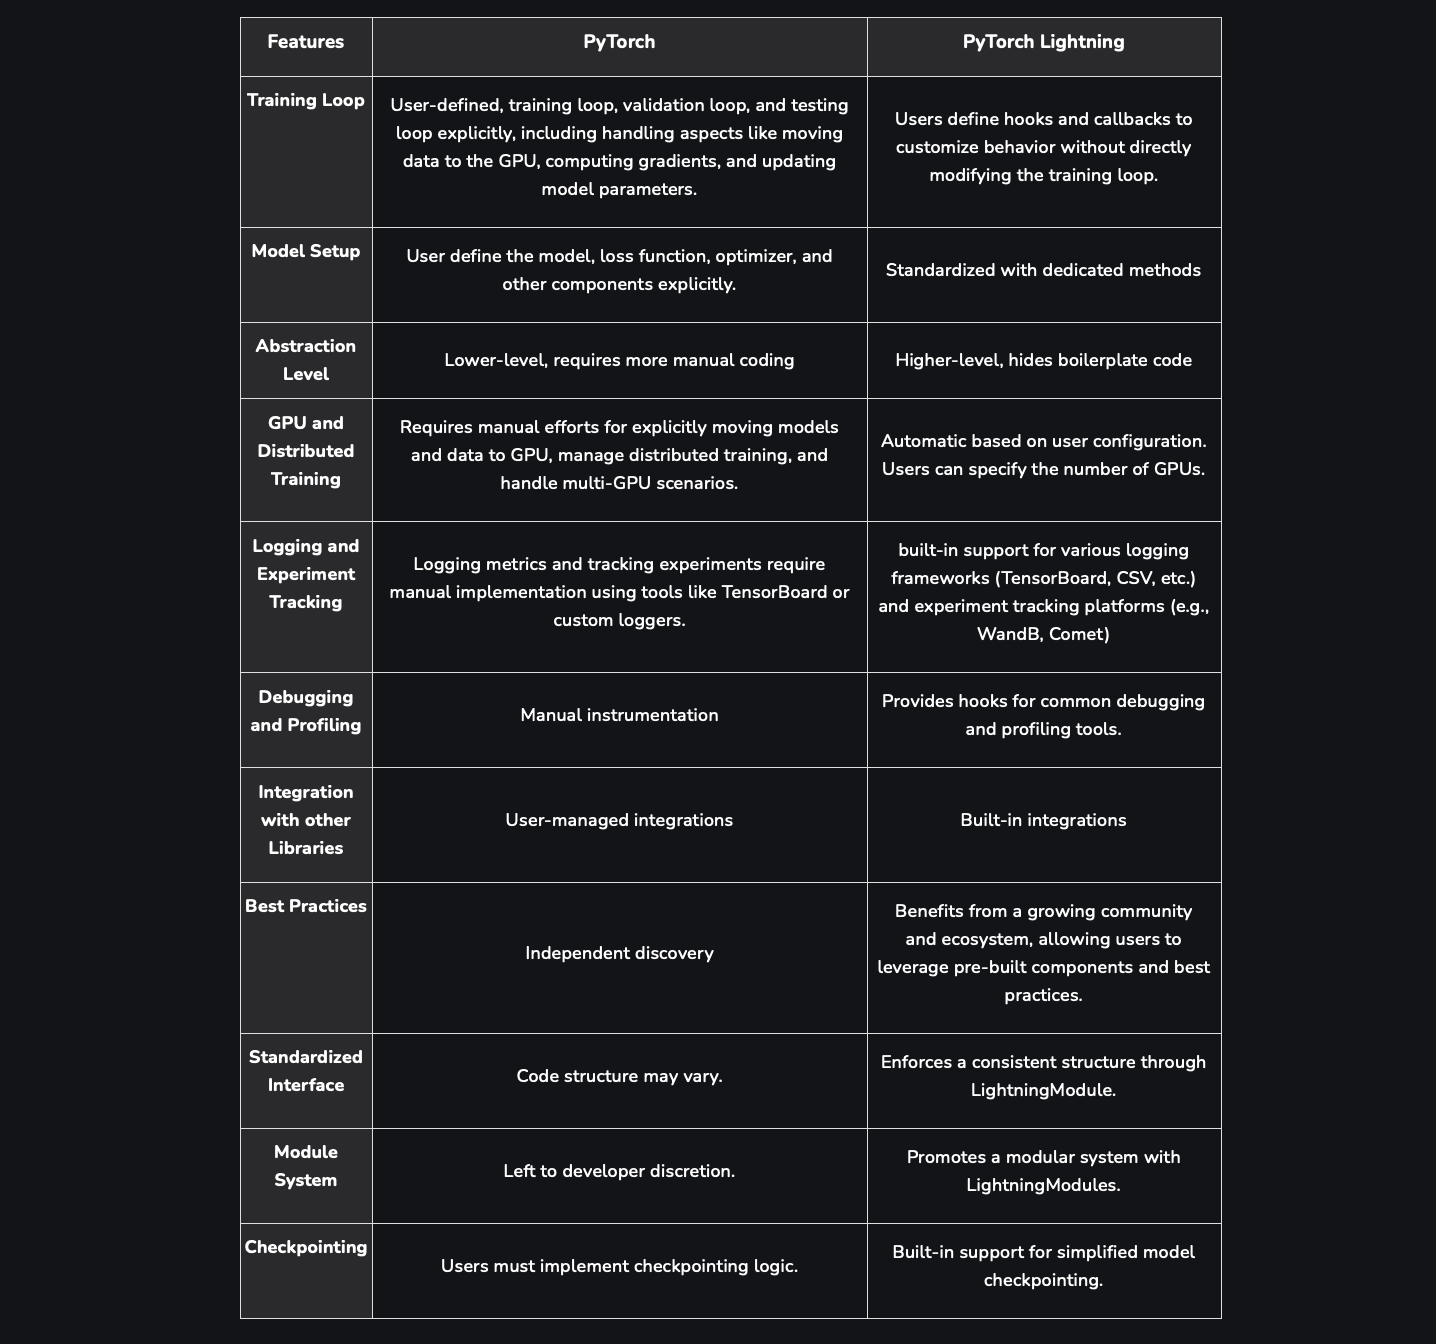

Now, for organising the process of loading the data, we use the PytorchLightning wrapper to wrap the previously coded DownscalingDataset class in a lightning friendly interface, the significance/handiness of which will be realised later. (short answer: it wraps dataloaders for the lightning TRAINER! wait for the long procedural answer which will be provided in due course ).



Just remember : while the DownscalingDataset class dictates how we load a single sample, the DownscalingDataModule dictates the entire organisation, splitting of datasets and batchification for the entire pipeline !

Can you complete the code below for the DownscalingDataModule?

In [ ]:
class DownscalingDataModule(LightningDataModule):
    def __init__(self, batch_size, val_frac, test_frac, num_workers, static_dir, save_stats_json):
        super().__init__()
        self.batch_size = ______
        self.val_frac = ________
        self.test_frac = _______
        self.________ = num_workers
        self.static_dir = ________
        self.________ = save_stats_json #Saving the standardisation stats in a .json file is a good idea, for use later (provided you are not standardising data on the fly!)


    def setup(self, stage=None):
        static_vars, stats = load_and_normalise(
            self.static_dir,
            val_frac=self.val_frac,
            ______=self.test_frac,
            save_stats_json=self.save_stats_json
        )
        file_list = get_file_list()
        dataset = DownscalingDataset(
            file_list, static_vars,
            low_2mt_mean=stats["low_2mt_mean"],
            low_2mt_std=stats[_______]
        )
        N = len(dataset)
        n_val = int(self.val_frac * N)
        n_test = int(self._____* ______)
        n_train = N - (_______+_____)
        self.train_set = torch.utils.data.Subset(dataset, range(0, n_train))
        self.val_set = torch.utils.data.Subset(dataset, range(n_train, n_train + n_val))
        self.______ = torch.utils.data.Subset(dataset, range(n_train + n_val, N))

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        _______________________________________________________________________________________________________

    def test_dataloader(self):
        ______________________________________________________________________________________________________

    @property
    def test_dataset(self):
        return self.test_set.dataset

Please note that in the following sections, we will sequentially go through the code for the entire pipeline, culminating in running the said pipeline in a single line of code with the suitable configurations!

### Q3 : UNet for Deterministic (Mean) Prediction
Now we start with the model hierarchy as laid down in the paper, starting with training the UNet. For this, we write two complementary classes. 1) A UNet class which defines the architecture of a simple UNet we will use for the deterministic prediction of high resolution 2m temperature field based on batchified inputs and 2) Again,the PytorchLightning wrapper that wraps around this UNet class and adds all the logical steps of training the model.

In [ ]:
# @title
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, channels, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, channels[0], kernel_size, padding=1)
        self.conv2 = nn.Conv2d(channels[0], channels[1], _________, _______)
        self.final = nn.Conv2d(channels[1], out_channels, 1)




    def forward(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        output = self.final(h)
        return _________

LightningModule for the above coded UNet class

Can you complete the code below and recognise how different it is from UNet class above?

In case you are curious about what the configuration object "cfg" does, it contains the list of hyperparameters that are customisable from a YAML configuration file. For now, complete the code below. Sequentially, we shall explain what it does in due time.

In [ ]:
class UNetLitModule(LightningModule):
    def __init__(
        self,
        net: torch.nn.Module = None,
        lr: float = 1e-3,
        optimizer: dict = None,
        scheduler: dict = None,
        loss_fn: torch.nn.Module = None,
        in_channels: int = 19,
        out_channels: int = 1,
        channels: list = [32, 16],
        kernel_size: int = 3,
    ):
        super().__init__()
        self.save_hyperparameters(logger=False, ignore=['net', 'loss_fn'])


        self.net = net if net is not None else UNet(
            in_channels=in_channels,
            out_channels=out_channels,
            channels=channels,
            kernel_size=kernel_size
        )
        self.loss_fn = loss_fn if loss_fn is not None else nn.MSELoss()
        self.lr = lr
        self.hparams.optimizer = optimizer
        self.hparams.scheduler = scheduler

    def forward(self, x):
        return self.net(x)

    def model_step(self, batch):
        fuzzy_input, sharp_target = batch
        pred = self.forward(_________)
        loss = self.loss_fn(pred, sharp_target)
        return loss, ______

    def training_step(self, batch, batch_idx):
        loss, pred = self.model_step(batch)
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, pred = self.model_step(batch)
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, pred = self.model_step(________)
        self.log("_______", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        opt_cfg = self.hparams.get("optimizer", None)
        sch_cfg = self.hparams.get("scheduler", None)
        if opt_cfg and opt_cfg["type"] == "AdamW":
            optimizer = torch.optim.AdamW(
                self.parameters(),
                lr=opt_cfg.get("lr", self.lr),
                betas=tuple(opt_cfg.get("betas", (0.5, 0.9))),
                weight_decay=opt_cfg.get("weight_decay", 1e-3)
            )
        else:
            optimizer = torch.optim.Adam(
                self.parameters(),
                lr=opt_cfg.get("lr", self.lr) if opt_cfg else self.lr,
                weight_decay=opt_cfg.get("weight_decay", 1e-4) if opt_cfg else 1e-4
            )
        if sch_cfg and sch_cfg["type"] == "ReduceLROnPlateau":
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                patience=sch_cfg.get("patience", 2),
                factor=sch_cfg.get("factor", 0.25)
            )
            return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": sch_cfg.get("monitor", "val/loss"),
                    "frequency": 1,
                },
            }
        else:
            return _________

### Q4: "Residual Learning" and predictive distributions: multiple equally valid answers ?

Although UNet is very powerful DL architecture and hence a strong baseline, it is only gives us the mean (deterministic, single answer) prediction. We need many samples conditioned on a coarse sample, as downscaling is a stochastic problem, with many different high resolution realities possible for a coarse input. This can be efficiently achieved using residual learning, which involves calculating pixelwise difference between outputs and the ground truth, and then "denoising" those residuals to generate samples we can add back to the mean prediction, to get more samples.

However, why do we do this? And why does this idea seem so trivial yet proved to be a gamechanger?

UNet, being a deterministic regression model , gives us the conditional mean of the distribution of possible high resolution samples conditioned on a low resolution input. Herein lies the problem with regression based point prediction. It gives us only the mean of the distribution. Unless we use a distribution to sample from, we cannot generate new samples.

However, due to the stochastic nature of downscaling, all different possibilities within the conditional distribution are possible realities! For more on conditional generative models , refer to https://visionbook.mit.edu/conditional_generative_models.html

Below is an excellent example of a true data distribution, point prediction (expected value), and two distributions (Gaussian and softmax) that can be sampled from basis our task

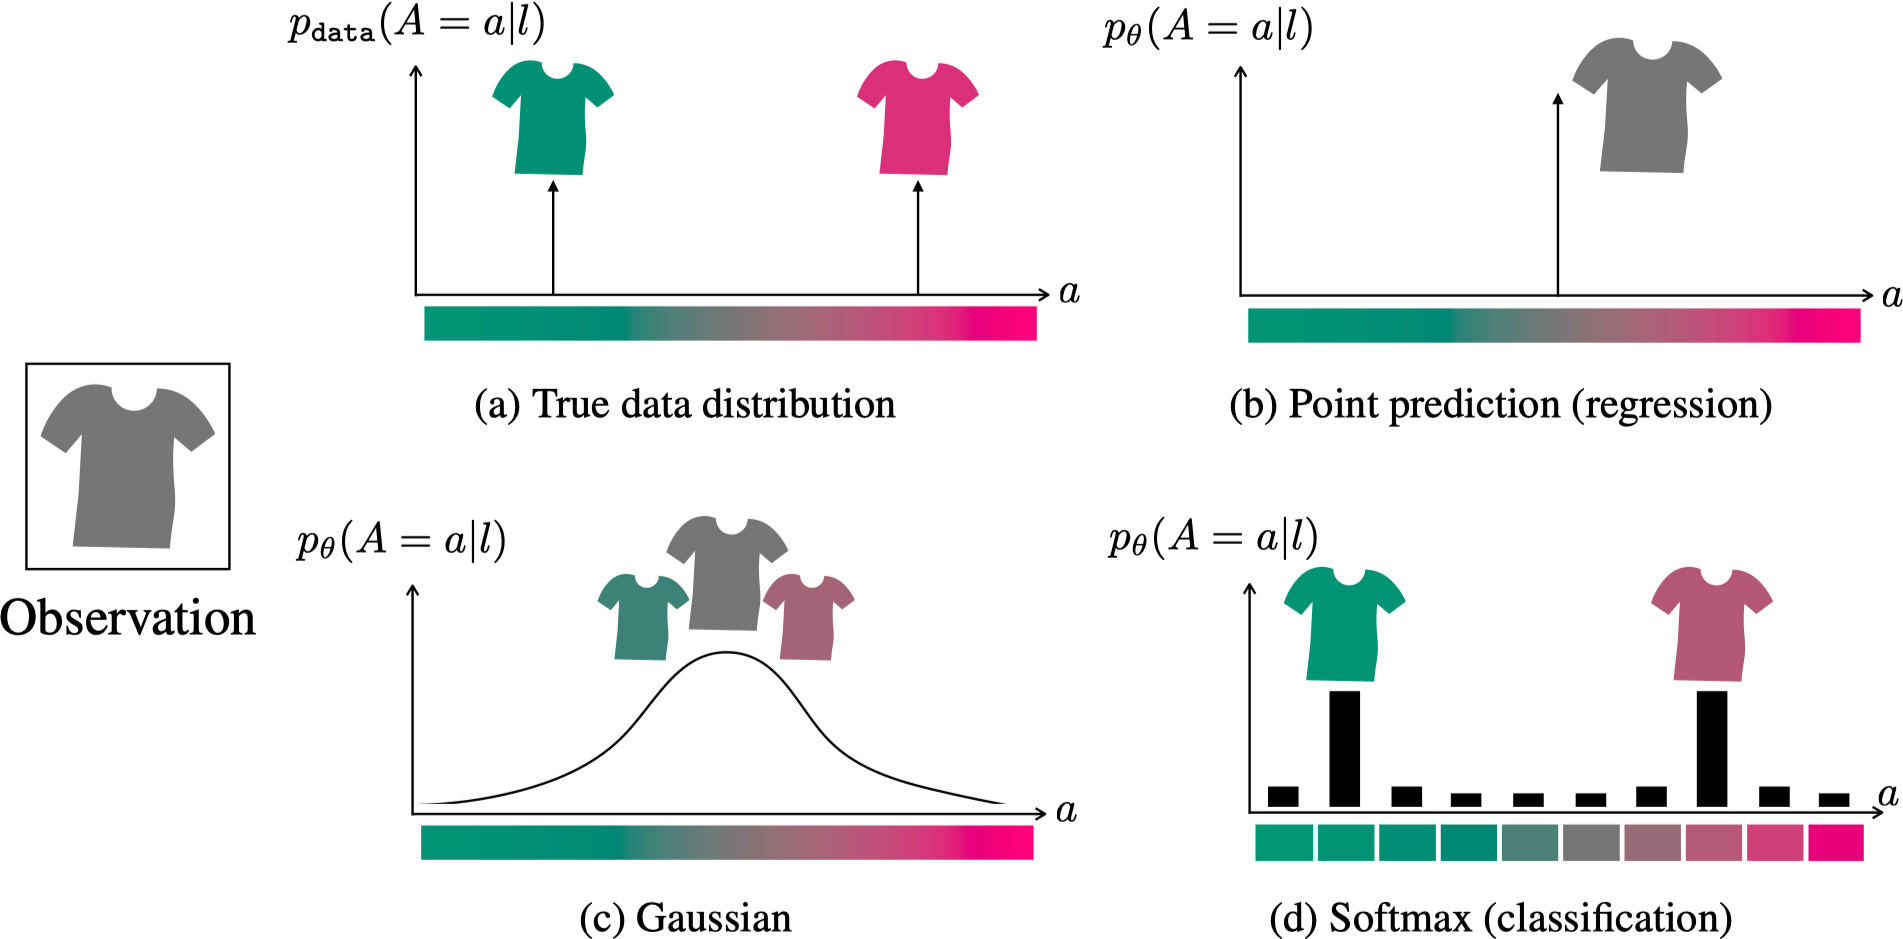

Image colorisation example. Source :  https://visionbook.mit.edu/conditional_generative_models.html

For conducting residual latent diffusion, we need an autoencoder to "encode" the residual between UNet prediction and the ground truth into latent space, followed by denoising and "reconstructing"/decoding the residuals back to pixel space to add to the UNet prediction. This way, we add different samples of the residual to the UNet prediction to "sharpen" the UNet prediction.

We now turn to generative modeling section, where we will take you step by step to actually generate samples from a conditional distribution, key to generative modeling.

###Q5. What is a Variational Autoencoder (VAE)?

We define a Variational Autoencoder as an infinite mixture model which makes use of the identity

\begin{aligned}
    p_{\theta}(\mathbf{x}) = \int_{\mathbf{z}} p_{\theta}(\mathbf{x} \bigm | \mathbf{z})p_{\mathbf{z}}(\mathbf{z})d\mathbf{z}
\end{aligned}

Hence a conditional VAE will make use of the identity to encode latent variable z independent of the inputs we are conditioning on,

\begin{aligned}
    p_{\theta}(\mathbf{y} \bigm | \mathbf{x}) = \int_{\mathbf{z}} p_{\theta}(\mathbf{y} \bigm | \mathbf{z}, \mathbf{x})p_{\mathbf{z}}(\mathbf{z})d\mathbf{z} \quad\quad \triangleleft
\end{aligned}

In context of climate downscaling, the simplest explanation for a Variational Autoencoder is that it is an architecture that encodes and decodes samples to/from latent space from the pixel space. The main idea is that the latent variable z should be "encoding"  information about the distributional target y  which is independent of what the conditional mean has already given us! This encoding/decoding is probabilistic, because encoder maps the input (in this cases, residuals from the UNet as we discussed before) to a distribution (with parameters mean and log_var). The decoder, after some process in the latent space has happened (diffusion in this case), reconstructs the input from the latent vector back to the pixel space. Practically in this case, the VAE will be used for encoding residual samples into for the diffusion denoising process.

For making our VAE work, we need a loss function, which is a combination of two types of losses :

1. KL divergence loss : defined as kl_divergence in the notebook,

kl_divergence : Computes the Kullback-Leibler Divergence, which is a metric which measures how much the learned latent distribution is different from a standard normal distribution (in this case, as it is temperature). In essence, this pushes the encoder decoder model to produce realistic latents distributed like a standard normal, so it can generalise well.  It is also known as relative entropy . For more, https://towardsdatascience.com/understanding-kl-divergence-f3ddc8dff254/. For a VAE parameterised as mu and log var , it can be written in the form

$$
\[
D_{\mathrm{KL}}\big(q(z|x)\,\|\,p(z)\big)
= \frac{1}{2} \sum_{j=1}^{d}
\left( \mu_j^2 + \sigma_j^2 - \log \sigma_j^2 - 1 \right).
\]
$$

In [ ]:
def kl_divergence(mean, log_var):  #mean and log var are parameters for a Gaussian for the latent variables
    kl = 0.5 * (log_var.exp() + mean.square() - 1.0 - log_var)
    return kl.mean()

Where P(x) and Q(x) are the two (in this case, Gaussian for temperature) distributions.

2. Reconstruction loss : This is simply L1 or L2 norm, measuring the error between reconstructed outputs and encoded inputs

Can you think of what makes an autoencoder variational? Hint : Conventional AEs use one deterministic loss!!! :)

###Q5.1. Notes on the reparameterisation trick : fundamental to the training of generative architectures in DL

In generative architectures such as the VAE, reconstruction of inputs does not happen exactly, but it is sampled and generated. In other words, it learns a probabilistic distribution, which is samples and decodes from. However, remember that for backpropagation, which is a cornerstone for gradient based optimisation, this sampling operation has to be expressed mathematically in a differentiable way. Herein lies the genius of the reparameterisation trick. Refer to the code cell below where the VAE class is defined

In [ ]:
class VAE(__________):
    def __init__(self, latent_dim=36, hidden_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hidden_dim, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (hidden_dim, 1, 1)),
            nn.ConvTranspose2d(hidden_dim, 32, 8, stride=8),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 84, stride=84),
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        return mu + std * torch.randn_like(std) #<---------------REPARAMETERISATION TRICK!!!

    def decode(self, z):
        h = self.fc_decode(z)
        x = self.decoder(____)
        x = F.interpolate(x, size=(672, 576), mode='bilinear', align_corners=False)
        return ______

    def forward(self, x, sample_posterior=True):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar) if sample_posterior else mu
        recon = self.decode(z)
        return recon, mu, ______

So what did we do? Instead of sampling z (latent variable) deterministically, we rewrote the sampling step so that the gradients can now flow from the loss back to the encoder. (Source : https://medium.com/@ml_dl_explained/understanding-the-reparameterization-trick-be349756b91b)

In a nutshell, mathematically,

The reparameterization trick allows backpropagation through a stochastic variable z. For a diagonal Gaussian:

$$
z = \mu + \sigma \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$

where:

- mu and sigma are the encoder outputs for input \(x\)  
- epsilon is random noise sampled from a standard normal

Now , the noise (randomness) is contained in e, and mean and sigma are differentiable again!

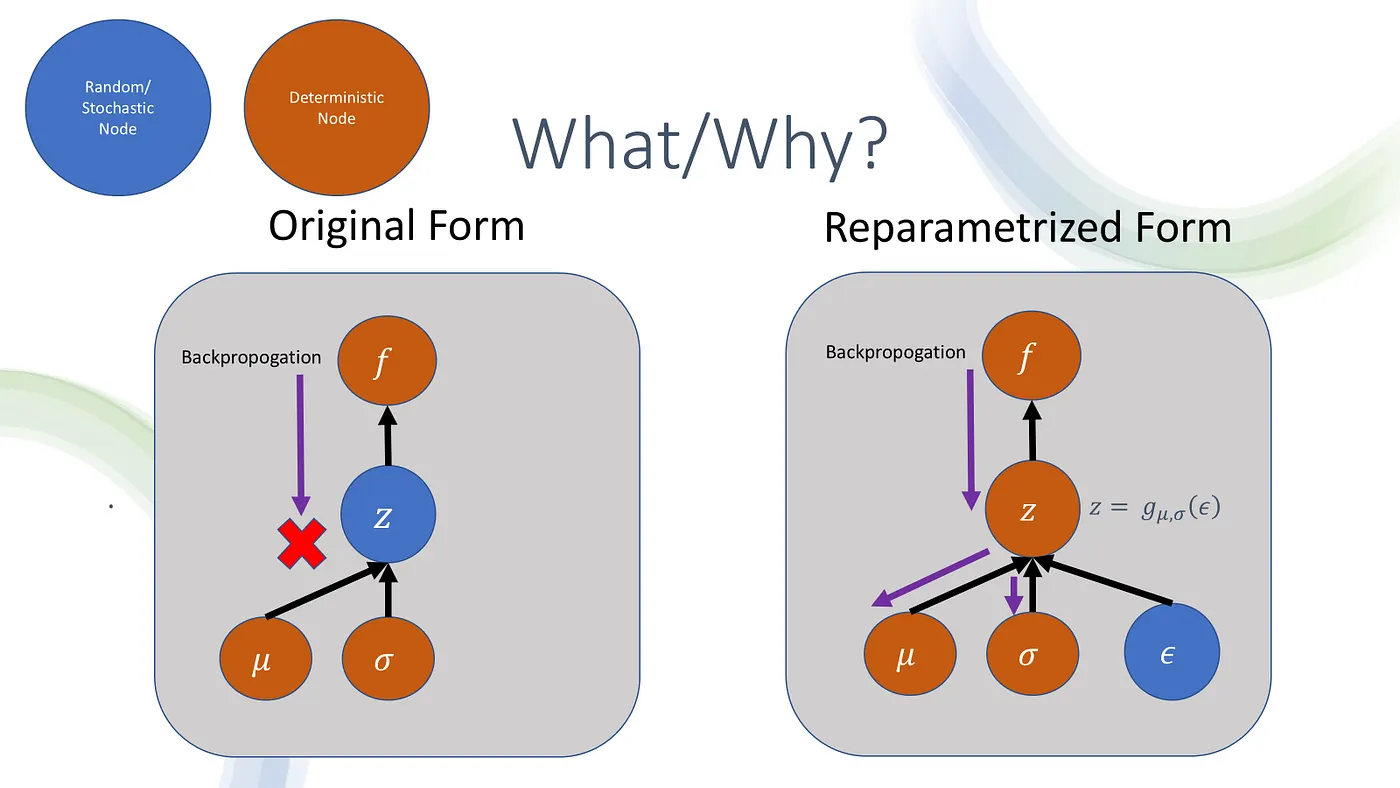

Back to being hands on, we have to wrap the VAE class above in a Lightning wrapper

In [ ]:
class VAELitModule(____________):
    def __init__(self, vae, unet_module, kl_weight=0.001, lr=1e-3):
        super().__init__()
        self.vae = vae
        self.unet = unet_module
        self.kl_weight = kl_weight
        self.lr = lr

    def training_step(self, batch, batch_idx):
        fuzzy_input, sharp_target = batch
        with torch.no_grad():
            unet_pred = self.unet(fuzzy_input)
        residual = sharp_target - unet_pred
        # Only use the UNet-predicted temperature channel as condition
        condition = unet_pred[:, 0:1]
        recon, mu, logvar = self.vae(residual) #encode residuals into latent space

        recon_loss = F.mse_loss(recon, residual)
        kl_loss = kl_divergence(mu, logvar)
        total_loss = recon_loss + self.kl_weight * kl_loss
        self.log("train/loss", total_loss)
        return total_loss

    def validation_step(_______, ________, ________):
        fuzzy_input, sharp_target = batch
        with torch.no_grad():
            unet_pred = self.unet(_________)
        residual = sharp_target - unet_pred
        condition = unet_pred[:, 0:1]
        recon, mu, logvar = self.vae(________) #encode residuals into latent space
        recon_loss = F.mse_loss(recon, _________)
        kl_loss = kl_divergence(mu, logvar)

        #What are the different components of the total VAE loss?
        total_loss = recon_loss + self.kl_weight * kl_loss
        self.log("val/loss", total_loss)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)




### Q5. Denoising UNet for the latent space (Latent Diffusion)

Now that we have the encoded residuals in latent space, we can use a denoise these latent vectors using a denoising UNet backbone for generating residual samples in the latent space, and then decode them back to pixel space to add to the original UNet mean prediction to generate samples of high resolution images conditioned on the coarse ERA5 + static predictors.

In the below LatentDenoiser class, we have coded a neural network that predicts the noise that is added to latent vectors at each diffusion timestep.  The VAE is frozen during training the denoiser. Following are the steps :


1. The VAE from the encoding decoding process is frozen, so that the encoded residuals are denoised in latent space by the UNet

2. The denoising UNet is instantiated, that predicts noise in the latent space

3. register_noise_schedule creates a schedule of noise levels (how much noise will be added at each step) for each timestep in the process of diffusion

4. The q_sample method adds noise to a latent at a given timestep t using the schedule prescribed above. It is used to simulate the diffusion forward by corrupting the latent gradually

6. p_losses samples a noisy latent vector at t and denoiser predictzs the noise that was added at t. It then computes losses between predicted noise and the true noise level according to schedule

7. sample : starts from completely random latent space noise and then performs iterative denoising using UNet denoiser and reverse diffusion. The final denoised latent is returned.

8. generate_samples : samples new latents using the diffusion proceess and finally decodes them back to pixel space as images of residuals to be added to UNet.

In [ ]:
class LatentDenoiser(________):
    def __init__(self, in_channels, out_channels, channels, kernel_size, context_channels=0):
        super().__init__()
        self.time_embed = nn.Sequential(
            nn.Linear(1, channels[0]),
            nn.ReLU(),
            nn.Linear(channels[0], channels[0])
        )
        self.unet = UNet(
            in_channels=in_channels + 2 + context_channels,  # +context_channels
            out_channels=out_channels,
            channels=channels,
            kernel_size=kernel_size
        )


    def forward(self, z_noisy, unet_pred, timestep=None, context=None):
        if timestep is None:
            timestep = torch.zeros(z_noisy.shape[0], 1, device=z_noisy.device)
        if timestep.dim()==1:
            timestep = timestep.unsqueeze(1)

        B, _, H, W = z_noisy.shape
        t_embed = self.time_embed(timestep.float())
        t_map = t_embed[:, :1].unsqueeze(-1).unsqueeze(-1).expand(-1, 1, H, W)
        inputs = [z_noisy, unet_pred, t_map]
        if context is not None:
            inputs.append(context)
        x = torch.cat(inputs, dim=1)
        return self.unet(________)


In [ ]:
class LDMLitModule(___________):
    def __init__(self, vae, latent_dim=36, conditioner=None, latent_height=6, latent_width=6, lr=1e-4, num_timesteps=50, noise_schedule="linear", loss_type="l2", hidden_dim=128, num_layers=4, param_type="eps", optimizer=None, scheduler=None):
        super().__init__()
        assert latent_dim == latent_height * latent_width,(f"latent_dim ({latent_dim}) must equal latent_height*latent_width ({latent_height}*{latent_width})")
        self.save_hyperparameters(logger=False, ignore=['vae'])
        self.vae = vae.vae.requires_grad_(False)
        self.latent_height = _________
        self.latent_width = __________
        self.vae.eval()
        self.unet = vae.unet
        self.conditioner = _________
        self.denoiser = LatentDenoiser(1, 1, [hidden_dim]*num_layers, 3, context_channels=1)
        self.lr = lr
        self.num_timesteps = __________
        self.loss_fn = {"l1": nn.L1Loss(), "l2": nn.MSELoss()}[loss_type]
        self.param_type = param_type
        self.register_noise_schedule(noise_schedule)
        self.hparams.optimizer = _________
        self.hparams.scheduler = _________




    def register_noise_schedule(self, schedule="linear"): #Can you think about what other noise schedules are available/possible here? Feel free to Google it!
        if schedule == "linear":
            betas = torch.linspace(1e-4, 2e-2, self.num_timesteps)

            #Can you distinguish linear and cosine noise schedules?
        elif schedule == "cosine":
            timesteps = torch.arange(self.num_timesteps + 1) / self.num_timesteps
            alphas = torch.cos(timesteps * torch.pi / 2) ** 2
            alphas = alphas / alphas[0]
            betas = 1 - alphas[1:] / alphas[:-1]
            betas = torch.clamp(betas, 0, 0.999)
        else:
            raise ValueError(f"Unknown schedule: {schedule}")  #Feel free to add other schedules here, we will see later how you can choose what to use in the model without changing the source code!

        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        self.register_buffer('betas', betas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1 - alphas_cumprod))

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        # Ensure t is [B] and expand to [B, 1, 1, 1] for broadcasting
        sqrt_alpha = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alpha * x_start + sqrt_one_minus_alpha * noise



    def sample(self, latent_shape, unet_pred_ds, context=None, device=None):
        if device is None:
            device = next(self.parameters()).device
        z = torch.randn(latent_shape, device=device)

        for t in reversed(range(self.num_timesteps)):
            t_tensor = torch.full((z.size(0),), t, dtype=torch.long, device=device)
            # Pass context to the denoiser!
            eps_pred = self.denoiser(z, unet_pred_ds, t_tensor, context=context)
            beta_t = self.betas[t]
            sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t]
            sqrt_recip_alpha_cumprod_t = 1.0 / self.sqrt_alphas_cumprod[t]

            z = (
                sqrt_recip_alpha_cumprod_t * (
                    z - beta_t / sqrt_one_minus_alpha_cumprod_t * eps_pred
                )
            )
            if t > 0:
                noise = torch.randn_like(z)
                sigma_t = torch.sqrt(beta_t)
                z = z + sigma_t * noise
        return z




    def p_losses(self, x_start, unet_pred, t, noise=______, context=______):
        if noise is None:
            noise = torch.randn_like(x_start)
        x_noisy = self.q_sample(x_start, t, noise)
        B = x_noisy.shape[0]
        x_noisy_4d = x_noisy.view(B, 1, self.latent_height, self.latent_width)
        unet_pred_ds = F.interpolate(unet_pred, size=(self.latent_height, self.latent_width), mode='bilinear', align_corners=False)
        context_ds = None
        if self.conditioner is not None and context is not None:
            context_ds = self.conditioner(_______)



        predicted = self.denoiser(x_noisy_4d, unet_pred_ds, t.unsqueeze(1).to(x_noisy.device), context=context_ds)

        # param can be "eps", "x0", or "v". : Can you differentiate how each parameterisation changes what the model predicts?
        if self.param_type == "eps":
            target = noise.view(B, 1, self.latent_height, self.latent_width)
        elif self.param_type == "x0":
            target = x_start.view(B, 1, self.latent_height, self.latent_width)
        elif self.param_type == _____:
            alpha_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
            sigma_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
            target = alpha_t * noise.view(B, 1, self.latent_height, self.latent_width) - sigma_t * x_start.view(B, 1, self.latent_height, self.latent_width)
        else:
            raise ValueError(f"Unknown param_type: {self.param_type}")

        return self.loss_fn(predicted, _______)




    def forward(self, fuzzy_input, unet_pred, sharp_target, context=None):
        with torch.no_grad():
            residual = sharp_target - __________
            mu, logvar = self.vae.encode(residual)
            z = self.vae.reparameterize(______, logvar)

        assert z.shape[1] == self.latent_height * self.latent_width, (
            f"Latent shape mismatch: got {z.shape}, expected ({-1}, {self.latent_height * self.latent_width})"
        )
        z = z.view(-1, 1, self.latent_height, self.latent_width)
        t = torch.randint(0, self.num_timesteps, (fuzzy_input.shape[0],), device=self.device)
        return self.p_losses(z, z, t, context=context)


    def training_step(self, batch, batch_idx):
        fuzzy_input, sharp_target = batch
        with torch.no_grad():
            unet_pred = self.unet(fuzzy_input)
        # Use UNet prediction (temperature channel) as context
        context = unet_pred[:, 0:1]
        loss = self.forward(fuzzy_input, unet_pred, sharp_target, context=context)
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss



    def _________________(_______, __________, _________):
        fuzzy_input, sharp_target = batch
        with torch.no_grad():
            unet_pred = self.unet(________)
        context = unet_pred[:, 0:1]
        loss = self.forward(__________, __________, _________, context=___________)
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss



    def test_step(self, batch, batch_idx):
        fuzzy_input, sharp_target = ________
        with torch.no_grad():
            unet_pred = self.unet(fuzzy_input)
        context = unet_pred[:, 0:1]
        loss = self.forward(fuzzy_input, unet_pred, sharp_target, context=context)
        self.log(__________, __________, ____________, _________, __________, ____________)
        return _______



    def configure_optimizers(self):
        opt_cfg = self.hparams.get("optimizer", None)
        sch_cfg = self.hparams.get("scheduler", None)
        if opt_cfg and opt_cfg.get("type") == "AdamW":
            optimizer = torch.optim.AdamW(self.parameters(), lr=opt_cfg.get("lr", self.lr), betas=tuple(opt_cfg.get("betas", (0.5, 0.9))), weight_decay=opt_cfg.get("weight_decay", 1e-3))
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=opt_cfg.get("lr", self.lr) if opt_cfg else self.lr, weight_decay=opt_cfg.get("weight_decay", 1e-4) if opt_cfg else 1e-4)
        if sch_cfg and sch_cfg.get("type") == "ReduceLROnPlateau":
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=sch_cfg.get("patience", 5), factor=sch_cfg.get("factor", 0.5))
            return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": sch_cfg.get("monitor", "val/loss"), "frequency": 1}}
        return optimizer


In the above LatentDenoiser class and LightningModule, we have coded a neural network that predicts the noise that is added to latent vectors at each diffusion timestep. The VAE is frozen during training the denoiser. The noise schedule (which can be either linear or cosine) controls how noise is added at each tiemstep. The module, in essence, learns to then generate or denoise latent represejntations using a diffusion process, making it possible to sample new, realistic data from the latent vectors back to pixel space.

In the original paper and repository, the authors condition on a range of variables to provide more context to the model, using AFNO (Attention Fourier Neural Operator) attention blocks. For the sake of simplicity, we use a simple CNN to downsample the UNet prediction and use it as "context" tensor , to be concatenated to the latent variable z. Simply put, the conditioner class is a simple neural network for providing conditional information to the denoising process during diffusion.  It serves the purpose of processing context data, eg., outputs a feature map that matches the latent space dimensions

In [ ]:
#for conditional generation:: a conditioner class

class Conditioner(____________):
    def __init__(self, in_channels, out_channels, latent_height, ________):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, out_channels, 3, padding=1),
            nn.AdaptiveAvgPool2d((latent_height, latent_width))
        )

    def forward(self, x):
        return self.net(______)

### Q6. Training the entire LDM_res hierarchy using a configuration file (YAML)
Now that we have the UNet, VAE and LDM classes along with their Lightning Modules, we are ready to train the entire hierarchy.


1) We split our low res high res pairs into training, validation and testing
2) Then we train the UNet to predict the conditional mean of the high resolution output.
3) To further sharpen the image that is the UNet prediction, we calculate the residuals (difference between UNet prediction and the ground truth) and encode it into latent space using the encoder of the VAE
4) Next, we "denoise" these residuals in latent space using the denoising UNet
5) The "decoder" of the trained VAE decodes (reconstructs) the image back to pixel space (these are residuals)


In case, these seem to be a lot of steps, please do not be overwhelmed. Go through the code step by step to understand

Please note that in the interest of time, we have already trained the models (unet, vae and ldm) for you. They are in your checkpoints directory. In any case, the train_hierarchy() function makes sure that you have both options : training your own models (if goodle colab and memory resources permit) as well as also load pretrained weights to visualise and analyse!

In [ ]:
def train_hierarchy(cfg):
    data_module = DownscalingDataModule(
        batch_size=cfg.data.batch_size,
        val_frac=cfg.data.val_split,
        test_frac=_____________,
        num_workers=______________,
        static_dir=_______________,
        save_stats_json=os.path.join(cfg.paths.output_dir, "stats.json")
    )
    data_module.setup()

    checkpoint_dir = cfg.paths.checkpoint_dir
    os.makedirs(checkpoint_dir, exist_ok=True)

    unet_ckpt_dir = os.path.join(checkpoint_dir, "unet")
    os.makedirs(unet_ckpt_dir, exist_ok=True)
    unet_ckpts = sorted([f for f in os.listdir(unet_ckpt_dir) if f.endswith(".ckpt")])



    if unet_ckpts:
        print("Loading pretrained UNet ckpt")
        unet_module = UNetLitModule.load_from_checkpoint(os.path.join(unet_ckpt_dir, unet_ckpts[-1]))
    else:
        print("Training UNet")
        unet_module = ___________(
            net=UNet(
                in_channels=cfg.model.unet.in_channels,
                out_channels=cfg.model.unet.out_channels,
                channels=cfg.model.unet.channels,
                kernel_size=cfg.model.unet.kernel_size,
            ),
            lr=cfg.model.unet.lr,
            optimizer=cfg.optimizer.unet,
            scheduler=cfg.scheduler.unet,
        )
        unet_checkpoint = ModelCheckpoint(
            dirpath=unet_ckpt_dir,
            filename="unet-{epoch:02d}",
            save_top_k=1,
            monitor="val/loss",
            mode="min",
        )


        trainer_unet = Trainer(
            max_epochs=cfg.training.unet_epochs,
            accelerator=cfg.trainer.accelerator,
            gradient_clip_val=cfg.trainer.get("gradient_clip_val", 1.0),
            enable_checkpointing=True,
            logger=False,
            callbacks=[unet_checkpoint],
        )
        ___________.fit(unet_module, datamodule=data_module)



    vae_ckpt_dir = os.path.join(checkpoint_dir, "vae")
    os.makedirs(vae_ckpt_dir, exist_ok=True)
    vae_ckpts = sorted([f for f in os.listdir(vae_ckpt_dir) if f.endswith(".ckpt")])



    if vae_ckpts:
        print("Loading pretrained VAE ckpt")
        vae = ________(latent_dim=cfg.model.vae.latent_dim,hidden_dim=cfg.model.vae.hidden_dim
)
        vae_module = ___________.load_from_checkpoint(
    os.path.join(vae_ckpt_dir, vae_ckpts[-1]),
    vae=vae,
    unet_module=unet_module
)
    else:
        print("Training VAE")
        vae = VAE(
            latent_dim=cfg.model.vae.latent_dim,
            hidden_dim=cfg.model.vae.hidden_dim
        )
        vae_module = VAELitModule(
            vae=vae,
            unet_module=unet_module,
            kl_weight=cfg.model.vae.kl_weight,
            lr=cfg.model.vae.lr
        )
        vae_checkpoint = _______________(
            dirpath=vae_ckpt_dir,
            filename="vae-{epoch:02d}",
            save_top_k=1,
            monitor="val/loss",
            mode="min",
        )
        trainer_vae = _____________(
            max_epochs=cfg.training.vae_epochs,
            accelerator=cfg.trainer.accelerator,
            enable_checkpointing=True,
            logger=False,
            default_root_dir=vae_ckpt_dir,
            callbacks=[vae_checkpoint],
        )
        ____________.fit(vae_module, datamodule=data_module)

    ldm_ckpt_dir = os.path.join(checkpoint_dir, "ldm")
    os.makedirs(ldm_ckpt_dir, exist_ok=True)
    ldm_ckpts = sorted([f for f in os.listdir(ldm_ckpt_dir) if f.endswith(".ckpt")])



    if ldm_ckpts:
        print("Loading pretrained LDM ckpt")
        ldm_module = LDMLitModule.load_from_checkpoint(os.path.join(ldm_ckpt_dir, ldm_ckpts[-1]), vae=vae_module)
    else:
        print("Training LDM")


        conditioner= ___________(
            in_channels= 1,
            out_channels= 1,
            latent_height=cfg.model.ldm.latent_height,
            latent_width=cfg.model.ldm.latent_width
        )

        ldm_module = LDMLitModule(
            vae=vae_module,
            conditioner=__________,
            latent_dim=cfg.model.ldm._________,
            latent_height=_____________________,
            latent_width=cfg.model.ldm.latent_width,
            lr=cfg.model.ldm.lr,
            num_timesteps=___________________,
            noise_schedule=cfg.model.ldm.noise_schedule,
            loss_type=cfg.model.ldm.loss_type,
            ____________=cfg.model.ldm.hidden_dim,
           _____________=cfg.model.ldm.num_layers,
            _____________=cfg.optimizer.ldm,
            scheduler=cfg.scheduler.ldm,
            param_type=______________,
        )
        ldm_checkpoint = ModelCheckpoint(
            dirpath=ldm_ckpt_dir,
            filename="ldm-{epoch:02d}",
            save_top_k=1,
            monitor="val/loss",
            mode="min",
        )
        trainer_ldm = Trainer(
            max_epochs=cfg.training.ldm_epochs,
            accelerator=cfg.trainer.accelerator,
            enable_checkpointing=True,
            logger=False,
            default_root_dir=ldm_ckpt_dir,
            callbacks=[ldm_checkpoint],
        )
        trainer_ldm.fit(___________, ___________=__________)

Now that our training hierarchy function is defined from beginning to end for training the entire hierarchy, how can we train it? In case we need to change anything, do we really go back through the entire model and change every single thing we want to change?



No need, that is where yaml files come in super handy! YAML is a data serialisation that is human readable and can be used to generate configuration files for conducting a range of experiments without changing the source code. For a primer on YAML : https://circleci.com/blog/what-is-yaml-a-beginner-s-guide/

For your first experiment, go ahead and write your first .yaml file using the code below , specifying the hyperparameters and settings. In case you do not specify anything, the default setting in the source code is used by the model

Unhide the code below for a pyyaml file with the configuration that we have used to train checkpoints with. Feel free to change parameters, and experiment with different configurations!

Let`s start by importing the omegaconf library

In [ ]:
from omegaconf import OmegaConf


Now, we are ready to write a configuration file! Feel free to change the value of the parameters to play with them. This is just the config file on which the pretrained models are configured upon. Please note that you can train your own models and save them separately in case you chose to play with the hyperparameters, but pretrained checkpoints are trained based on the configuration written below!

In [ ]:

cfg_dict = {
    "data": {
        "batch_size": 32,
        "num_workers": 1,
        "test_split": 0.15,
        "val_split": 0.15,
    },
    "model": {
        "ldm": {
            "hidden_dim": 64,
            "latent_height": 6,
            "latent_width": 6,
            "latent_dim": 36,
            "loss_type": "l2",
            "lr": 0.0001,
            "noise_schedule": "linear",
            "num_layers": 2,
            "num_timesteps": 20,
            "param_type": "eps",
        },
        "unet": {
            "channels": [32, 16],
            "in_channels": 19,
            "kernel_size": 3,
            "lr": 0.0001,
            "out_channels": 1,
        },
        "vae": {
            "decoder_channels": [8],
            "encoder_channels": [8],
            "hidden_dim": 128,
            "input_channels": 2,
            "input_height": 672,
            "input_width": 576,
            "kl_weight": 0.001,
            "latent_dim": 36,
            "lr": 0.0001,
        },
    },
    "optimizer": {
        "ldm": {
            "betas": [0.5, 0.9],
            "lr": 0.0001,
            "type": "AdamW",
            "weight_decay": 0.001,
        },
        "unet": {
            "lr": 0.0001,
            "type": "Adam",
            "weight_decay": 0.0001,
        },
        "vae": {
            ______: [0.5, 0.9],
            _______: 0.0001,
            _______: "AdamW",
           ________: 0.001,
        },
    },
    "paths": {
        "checkpoint_dir": "/content/drive/MyDrive/data_LDM/checkpoints",
        "data_dir": "/content/drive/MyDrive/data_LDM/",
        "output_dir": "./",
        "static_dir": "/content/drive/MyDrive/data_LDM/static_vars",
    },
    "scheduler": {
        "ldm": {
            "factor": 0.25,
            "monitor": "val/loss",
            "patience": 3,
            "type": "ReduceLROnPlateau",
        },
        "unet": {
            "factor": 0.25,
            "monitor": "val/loss",
            "patience": 3,
            "type": "ReduceLROnPlateau",
        },
        "vae": {
            "factor": 0.25,
            "monitor": "val/recon_loss",
            "patience": 3,
            "type": "ReduceLROnPlateau",
        },
    },
    "seed": 42,
    "trainer": {
        "accelerator": "gpu",
        "gradient_clip_val": 1.0,
        "max_epochs": 10,
        "min_delta": 0.0001,
    },
    "training": {
        "ldm_epochs": 20,
        "unet_epochs": 20,
        "vae_epochs": 20,
    },
}



In [ ]:
cfg = OmegaConf.create(cfg_dict) #Can you go back and inspect in what places we have used cfg objects while writing our Lightining Modules?
OmegaConf.save(cfg, "config_experiments.yaml")

You should now see the configuration file in your present working directory. Open it and inspect whether it is the same as what we wrote above!

Now go ahead and create this .yaml file and load it later in the cfg variable (as that is how it is referred to in the source code for all the pytorch and lightning wrappers). Now you know what cfg is in all the LightningModules!

In [ ]:
import yaml

with open("config_experiments.yaml", "w") as f:
    yaml.dump(cfg_dict, f, default_flow_style=False)

For loading the above file, we can use a range of other libraries such as OmegaConf (a YAML based hierarchical configuration system) or Hydra (built on OmegaConf, with even more advanced functionalities for configuring experiments). For now, we use OmegaConf. For a primer on OmegaConf and Hydra , refer : https://medium.com/data-science/keeping-up-with-pytorch-lightning-and-hydra-2nd-edition-34f88e9d5c90  and https://majianglin2003.medium.com/python-omegaconf-a33be1b748ab#567f. For piquing your interest, here is the adorable official Hydra logo :)

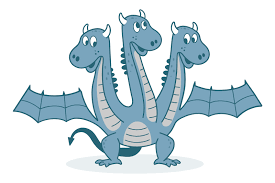

For the purposes of runnign this pipeline, we stick to OmegaConf

### Q7: For running the entire pipeline, you just have to run the below cell !!!(Do you see the utility of having experimental configurations and super modularised code?)

In [ ]:
cfg = OmegaConf.load("______________")
train_hierarchy(cfg) #Make sure to run this on a GPU!!!

Using 24 of 48 files from 2020.


KeyboardInterrupt: 

You can see that the UNet and VAE are being loaded from a pretrained checkpoint. This is for saving time ! As the entire hierarchy of sequential models will take very long to train (approx 45 minutes from our experience of training it), we have ensured that you have pretrained models at oyur disposal. But feel free to try training it on your own. See if you can train the UNet and VAE after class.

### Q7b. Inference pipeline for visualising a single frame and generated samples


 Fill out the code cell below to load the three pretrained architectures, and visualising a single frame from coarse input all the way to high resolution samples .

  The below code 🇰

1.  Loads standardisation stats from the .json file saved before
2. Initialised the data module and loads the test set
3. Loads the checkpointed models (UNet, VAE and LDM) and sets all models to eval mode
4. Selects a random test frame for inference and prepares as input for the pixel UNet
5. Runs the frame through the heirarchy (UNet, encoding of residuals, VAE, LDM and decoding)
6. Samples three samples (latent vectors) from VAE, decodes them to generate three possible residuals, and adds these to the UNet to predict three different reconstructions
7. Finally destandardises all outputs for visualising the frames and plots the six images : ground truth, ERA5 input field, UNet prediction, three generated samples

Start by setting up the test dataloader:

In [ ]:
data_module = ______________(
    batch_size=1,
    val_frac=cfg.data.val_split,
    test_frac=cfg.data.test_split,
    num_workers=cfg.data.num_workers,
    static_dir=cfg.paths.static_dir,
    save_stats_json=os.path.join(cfg.paths.output_dir, "stats.json")
)
data_module.setup()



____________ = data_module.test_dataloader()

# Get a single test sample (input and ground truth)
test_iter = iter(test_loader)
input_sample, ground_truth = next(test_iter)


input_sample = ____________
ground_truth = ground_truth[0]

Using 24 of 48 files from 2020.
Using 24 of 48 files from 2020.


In [ ]:
def inference_random_frame(cfg, input_sample, ground_truth=None, return_array=False):


    stats_path = os.path.join(cfg.paths.output_dir, "stats.json")
    with open(stats_path, "r") as f:
        stats = json.load(f)
    low_2mt_mean = stats["low_2mt_mean"]
    low_2mt_std = stats[___________]

    def denormalise(arr):
        return arr * low_2mt_std + ___________

    # Load models
    unet_ckpt_dir = os.path.join(cfg.paths.checkpoint_dir, "unet")
    unet_ckpt = sorted(os.listdir(unet_ckpt_dir))[-1]
    unet_module = UNetLitModule.load_from_checkpoint(os.path.join(unet_ckpt_dir, unet_ckpt))

    vae_ckpt_dir = os.path.join(cfg.paths.checkpoint_dir,_________)
    vae_ckpt = sorted(os.listdir(vae_ckpt_dir))[-1]
    vae = VAE(latent_dim=cfg.model.vae.latent_dim, hidden_dim=cfg.model.vae.hidden_dim)
    vae_module = ____________.load_from_checkpoint(os.path.join(vae_ckpt_dir, vae_ckpt), vae=vae, unet_module=unet_module)

    ldm_ckpt_dir = os.path.join(cfg.paths.checkpoint_dir, "ldm")
    ldm_ckpt = sorted(os.listdir(ldm_ckpt_dir))[-1]
    ldm_module =____________._____________(os.path.join(ldm_ckpt_dir, ldm_ckpt), vae=vae_module)

    unet_module.eval()
    vae_module.eval()
    __________.________

    conditioner= ldm_module.conditioner
    _________.______()

    with torch.no_grad():
        device = next(unet_module.parameters()).device
        fuzzy_input = input_sample.unsqueeze(0).to(device)  # [1, C, H, W]
        unet_pred = unet_module.net(fuzzy_input)            # [1, 1, H, W]

        unet_pred_np= unet_pred[0, 0].cpu().numpy() #Height and Width

        latent_height = cfg.model.ldm.latent_height
        ___________ = cfg.model.ldm.latent_width
        latent_shape = (1, 1, latent_height, latent_width)

        unet_pred_ds = F.interpolate(unet_pred, size=(latent_height, latent_width), mode='bilinear', align_corners=False)
        context_tensor = conditioner(unet_pred_ds)  # [1, 1, latent_height, latent_width]

            # Generate 3 samples
        final_reconstructions = []



        for _ in range(3):
            z_sample = ldm_module.sample(latent_shape, unet_pred_ds, context=context_tensor)
            z_sample_flat = z_sample.view(z_sample.size(0), -1)
            generated_residual = vae_module.vae.decode(z_sample_flat)
            final_reconstruction = unet_pred + generated_residual
            final_reconstructions.append(final_reconstruction[0, 0].cpu().numpy())


    if return_array:
        return np.stack(final_reconstructions, axis=0),unet_pred_np #Stacking a set of 3 predictions per input sample



    all_imgs = [
        denormalise(fuzzy_input[0, 0].cpu().numpy()),  # ERA5 predictor
        denormalise(unet_pred_np),                     # UNet prediction
        *[denormalise(img) for img in final_reconstructions],  # 3 samples
    ]
    titles = [
        "ERA5 2m input",
        "UNet Prediction",
        "Sample 1",
        __________,
        _________,
    ]

    # Add ground truth if provided
    if ground_truth is not None:
        all_imgs.append(denormalise(ground_truth.cpu().numpy().squeeze()))
        titles.append("Ground Truth")

    vmin = min(img.min() for img in all_imgs)
    vmax = max(img.max() for img in all_imgs)

    fig, axes = plt.subplots(1, len(all_imgs), figsize=(6 * len(all_imgs), 6), constrained_layout=True)
    images = []

    for i, ax in enumerate(axes):
        im = ax.imshow(all_imgs[i], cmap='coolwarm', vmin=vmin, vmax=vmax, origin='upper')
        ax.set_title(titles[i], fontsize=15, fontweight='bold')
        ax.set_xlabel("Longitude", fontsize=13)
        ax.set_ylabel("Latitude", fontsize=13)
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.grid(False, which='both')
        images.append(im)

    cbar = fig.colorbar(images[0], ax=axes, orientation='horizontal', fraction=0.04, pad=0.08)
    cbar.set_label("2m Temperature (C)", fontsize=15, fontweight='bold')
    cbar.ax.tick_params(labelsize=13)

    plt.suptitle("ERA5 low res + 3 samples + Ground Truth (conditional inference)", fontsize=20, y=1.05, fontweight='bold')
    _______._____()

To run the above inference pipeline , just run the below cell with the previously created configuration file!

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'conditioner' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['conditioner'])`.


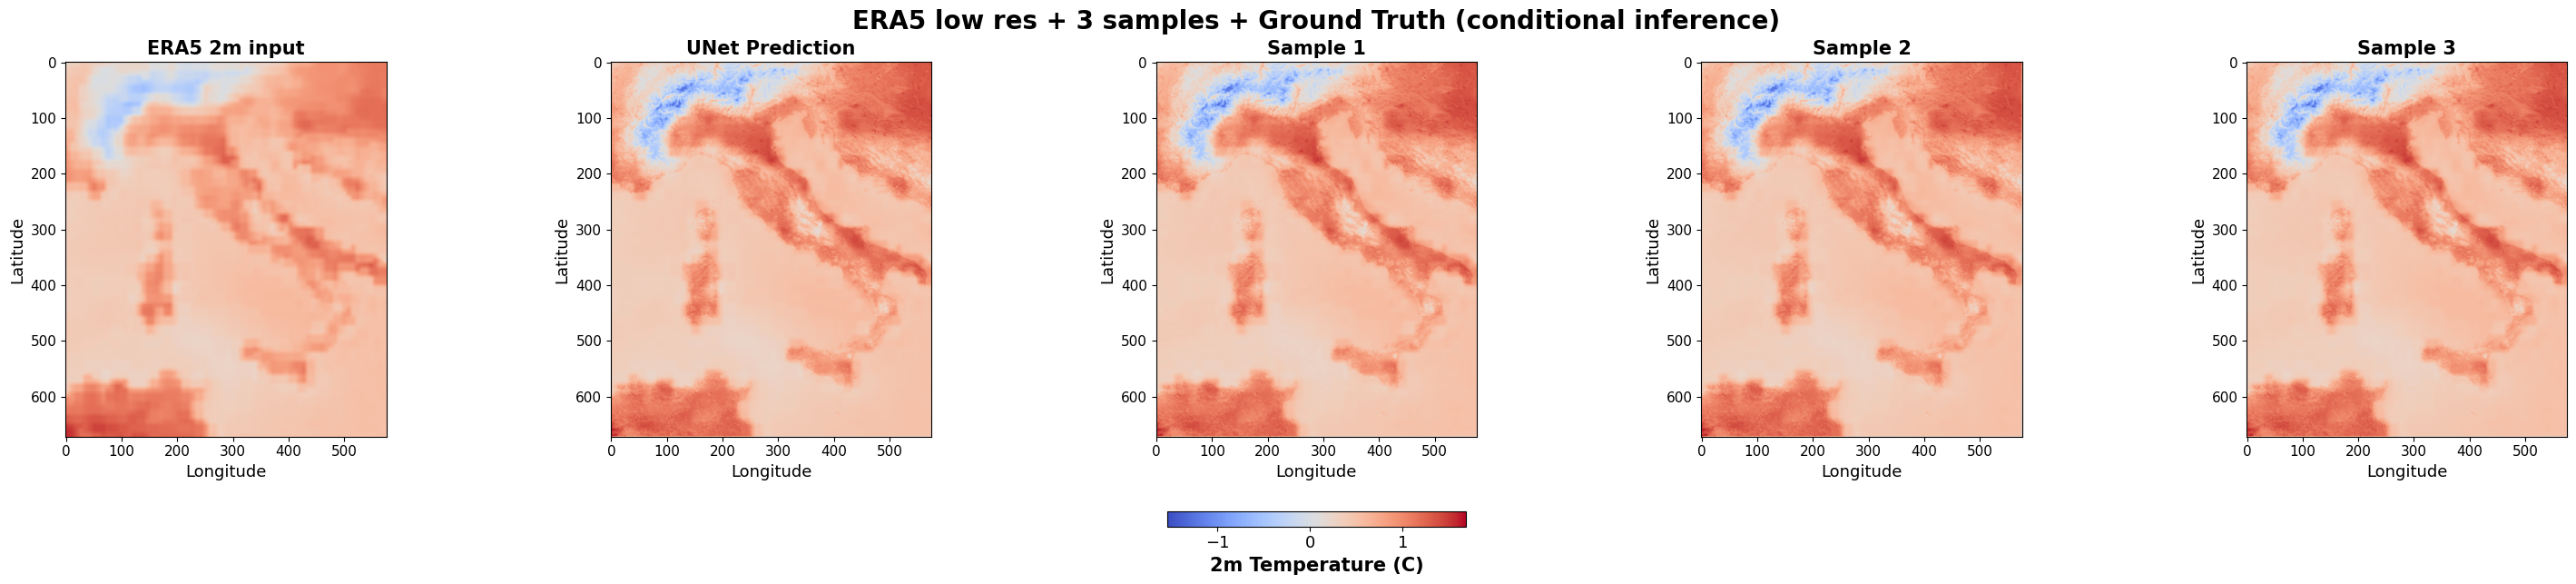

In [ ]:
inference_random_frame(________, input_sample)

### Q8: Can you establish the added value of generative downscaling ?

No matter how wonderful and close to the ground truth (target) your frame looks, we have to calculate some metric on th test set to establish the overall added value of UNet and the VAE+LDM over simple bilinear interpolation! As you have already seen CRPS score before, let us go ahead and calculate it

In [ ]:
!pip install properscoring

In [ ]:
from properscoring import crps_ensemble

In [ ]:
all_crps_ldm = []
all_crps_era5 = []
__________ = []

Now we write the loop to generate 3 samples for each frame in the test set

In [ ]:
for input_sample, ground_truth in data_module.test_dataloader():


#Take care of the following : the crps_ensemble() function takes channels last, many times tensors have channel first
    # input_sample: (batch, C, H, W) or (batch, H, W)
    # ground_truth: (batch, 1, H, W) or (batch, H, W)

    for i in range(input_sample.shape[0]):

        inp = input_sample[i][0].cpu().numpy().squeeze()

        gt = ground_truth[i][0].cpu().numpy().squeeze()


        samples, unet_pred = inference_random_frame(cfg, input_sample[i], ground_truth=None, return_array=True)
        samples = np.moveaxis(samples, 0, -1)

        crps_ldm = crps_ensemble(gt, samples)
        all_crps_ldm.append(np.mean(crps_ldm))

        era5_ensemble = np.repeat(inp[..., None], 3, axis=-1)
        crps_era5 = crps_ensemble(gt, era5_ensemble)
        all_crps_era5.append(np.mean(crps_era5))


        unet_ensemble = np.repeat(unet_pred[..., None], 3, axis=-1)


        crps_unet = crps_ensemble(gt, unet_ensemble)
        all_crps_unet.append(np.mean(__________))

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'conditioner' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['conditioner'])`.


In [ ]:
print("Mean CRPS (ERA5):", np.mean(all_crps_era5))
print("Mean CRPS (UNet):", ___________(___________))
print("Mean CRPS (LDM):", ___________(all_crps_ldm))

Mean CRPS (ERA5): 0.17299744647394988
Mean CRPS (UNet): 0.1433810331870353
Mean CRPS (LDM): 0.14298078700400776


How does your CRPS look for Unet and LDM as compared to coarse inputs from ERA5 (predictor)? Did it improve ?

Through this illustrative exercise, we find the potential of LDMs as cost-effective, robust alternatives for downscaling applications (e.g., downscaling of climate projections), where computational resources are limited but high-resolution data are critical. Happy learning!